# Data origin

TweetsCongress (Congressional Tweets Dataset -- 2008-2017 data)

This dataset is designed for a training exercise from SQL for Data Science Capstone Project. The main objective is to analyze the 2008-2017 congressional tweets in order to understand key topics, members, and relationships within Congress.
Two JSON files make up the dataset, one gathering the Twitter accounts of members of Congress and the other all the actions (tweets, retweets, etc.) of these accounts.

__Report purpose: target audience__
This current exploratory work could be useful to those in charge of the communication tools of members of Congress. Indeed, the person(s) in charge (who can be exclusively the member of the congress itself) could appreciate knowing that a greater visibility on Twitter (ie posting and interacting regularly) is strongly correlated with a greater number of followers. Just like knowing the key points and the recurring words in the communication of the members of a party and the opposition allows to better target and position the message of the tweets. These insights will help them focus and strengthen their efforts. This is why this report looks for potential patterns on a few specific points of the various congress members' Twitter accounts and the way they tweet.

# Methodology

Problematic
There are three types of questions I would like to answer.

1. The relationship between popularity and activity on Twitter as well as the states population of members of Congress.

2. Do members of Congress from more populous states have more followers?
3. Do members of Congress who post the most have the most followers?

What are the most used words and hashtags by members of Congress?

Do the colors of the images of the Twitter account (profile and cover) are mainly split between red and blue ?

# Hypotheses

I assume, the more a member of Congress tweets the more he/she is being followed. The same assumption is made regarding the population of the states. However, the date of creation of the twitter account should strongly model these assumptions, at least in the short term.

I don't have a strong prediction of which words / hashtags are used the most, but chances are that among them are the words Democrat and Republican, as well as Obama and Trump (and / or a compound word like Obamacare).

There is a good chance that the colors red and blue are used a lot depending on the parties of members of Congress. However, the result could be biased by how to measure / calculate the dominant color of the whole image or a piece of it.

# Approach

The two JSON files of the dataset will be cleaned in order to retrieve the variables necessary to respond to the various questions.

The most important variables to select are the ID of Twitter accounts, their number of followers and posts, the colors of profile images, and the texts of tweets. Some ancillary variables can be useful for a better understanding of the data, such as the creation date of Twitter accounts, and the publication date of tweets.

Since one of the two JSON files is very large, it is useful to integrate both into a relational database in order to be able to execute python commands more efficiently, in particular thanks to the RDBMS API and SQL queries.

Finally, these features will make it possible to obtain graphs showing the different trends and lexical analyzes.

# Data architecture

From the features needed to answers our problematics, a EDR with the following connection are made:

![EDR](EDR.png) 

- Users db are connected Tweets(Json) through user_id.
- and the same db is connected to State(Web scrapping) through the state column.

# Data processing

In [88]:
#importing libraries
import pandas as pd
import numpy as np
import math
from scipy import stats
from IPython.display import display

import nltk
from nltk import word_tokenize

import datetime
from datetime import datetime as dt
import re
import time

import sqlite3
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import os

import matplotlib
from matplotlib import cm
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
%matplotlib inline

pd.set_option('display.max_rows', 11)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Extracting and loading data

In [2]:
import tarfile

with tarfile.open("./US_PoliticalTweets.tar.gz") as open_file:
    open_file.extractall("./data")

In [3]:
os.listdir("./data")

['CongressTweets.db', 'tweets.json', 'users.json']

In [4]:
users = pd.read_json('data/users.json', orient='values', lines=True, convert_dates=False)

In [5]:
tweets = pd.read_json('data/tweets.json', orient='values', lines=True)

# Data Cleaning

Since some dates (i.e. created_at) are under a different format in users file, these data points need to be reformatted to fit the others, which are timestamp format. Then, the feature can properly be cast as a regular datetime format.

Also, some features are quite rare, if not completely empty, in the tweets file. In consequence, they'll be removed.

In [6]:
is_timestamp = users['created_at'].astype(str).apply(lambda x: re.search('\D', x)).isna()

users['created_at'][~is_timestamp] = users['created_at'][~is_timestamp].apply(
                                        lambda x: dt.timestamp(dt.strptime(x, '%a %b %d %H:%M:%S %z %Y')))
users['created_at'] = users['created_at'].transform(dt.fromtimestamp)

C:\Users\anmur\AppData\Local\Temp\ipykernel_28664\2833199447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['created_at'][~is_timestamp] = users['created_at'][~is_timestamp].apply(


In [7]:
tweets.drop(columns=['contributors', 'withheld_copyright', 'withheld_in_countries', 'withheld_scope'], inplace=True)
tweets['display_text_range'] = tweets['display_text_range'].astype(str)

## Getting an official list of US states and abbreviations

In [9]:
# Web scrapping
url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States'
calls_df = pd.read_html(url) #, header=1)

states = pd.DataFrame(calls_df[1]).iloc[:,0:2]
federal_dc = pd.DataFrame(calls_df[2]).iloc[:,0:2]
territories = pd.DataFrame(calls_df[3]).iloc[:,0:2]

# Renaming columns
states.columns = ['name', 'abbrevation']
federal_dc.columns = ['name', 'abbrevation']
territories.columns = ['name', 'abbrevation']

# Data cleaning
filt = states['name'].str.contains('[E]', na=False) # na=False remplace na par un bool

states.loc[filt,'name'] = states.loc[filt,'name'].str.replace('\[E\]', '', )

# Merge df
states_names = pd.concat([states, federal_dc, territories],
                        ignore_index=True)

states_names.head()

name abbrevation
0     Alabama          AL
1      Alaska          AK
2     Arizona          AZ
3    Arkansas          AR
4  California          CA

## Retrieving state names from acount description and location vars

In [10]:
# Transform df into a single list => better to iterate
names_abbr = states_names['name'].values.tolist()
names_abbr.extend(states_names['abbrevation'].values.tolist())

# Search for states' names & abbrv in the description feature, then add the location feature
def find_state(series, states_names):
    description = series.iloc[0]
    location = series.iloc[1]
    
    statename = set()
    
    for word in states_names:
        re_pattern = f"\W({word})[^a-zA-Z]|\W({word})$|^({word})[^a-zA-Z]"
        descr_match = re.findall(re_pattern, description)
        if descr_match != []:
            descr_match = ' '.join(descr_match[0]).strip()
            statename.add(descr_match)
        
        loc_match = re.findall(f"{re_pattern}|({word})", location)
        if loc_match != []:
            loc_match = ' '.join(loc_match[0]).strip()
            statename.add(loc_match)
            
    return statename

def rm_duplicates(series, states_names):
    result = set()
    for word in series:
        if word in states_names['abbrevation'].values.tolist():
            result.add(states_names.set_index('abbrevation').loc[word,'name'])
        if word in states_names['name'].values.tolist():
            result.add(word)
    
    # Hard rules since DC is popular in location feature, probably because it's the capital city
    if ('District of Columbia' in result) and ('Washington' in result):
        result.remove('District of Columbia')
        
    if ('West Virginia' in result) and ('Virginia' in result):
        result.remove('Virginia')
        
    if len(result) > 1 and ('District of Columbia' in result):
        result.remove('District of Columbia')
        
    if len(result) > 1 and ('Washington' in result):
        result.remove('Washington')
        
    if len(result) > 1 and ('California' in result):
        result.remove('California')
        
    return result

users['state'] = users[['description', 'location']].apply(find_state, args=(names_abbr,), axis=1)
users['state'] = users['state'].apply(rm_duplicates, args=(states_names,))

# Transform valid data (ie 1 name only) from set to str
filt = users['state'].apply(lambda x: len(x) == 1)
users.loc[filt, 'state'] = users.loc[filt, 'state'].apply(''.join)
# Remove unvalid data (ie 0/2 etc names)
users.loc[~filt, 'state'] = ''

In [11]:
matches = len(users.loc[users['state'] != '', 'state'])
prop = round(100 * matches / len(users['state']),1)
print(f"Number of states retrieved: {matches} from {len(users['state'])} entries ({prop}%)")

Number of states retrieved: 510 from 548 entries (93.1%)


## Getting an official list of population for each State

In [12]:
# Web scrapping
url = 'https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population'
calls_df = pd.read_html(url, header=0)

us_population = pd.DataFrame(calls_df[0]).iloc[0:56,[2,3,10]]
us_population.columns = ['state','population','percentage']

us_population['percentage'] = us_population['percentage'].str.replace('%', '').astype(float)

us_population.head()

# Join population dataframe with Twitter accounts
# users = users.merge(us_population, on='state', how='left')

state  population  percentage
0    California    39538223       11.80
1         Texas    29145505        8.70
2       Florida    21538187        6.43
3      New York    20201249        6.03
4  Pennsylvania    13002700        3.88

# Writing into SQLite DB

In [13]:
conn = sqlite3.connect('data/CongressTweets.db')

with conn:
    c = conn.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS users (
                    contributors_enabled                TEXT   ,
                    created_at                          TEXT   ,
                    default_profile                     TEXT   ,
                    default_profile_image               TEXT   ,
                    description                         TEXT   ,
                    favourites_count                    INTEGER,
                    follow_request_sent                 TEXT   ,
                    followers_count                     INTEGER,
                    following                           TEXT   ,
                    friends_count                       INTEGER,
                    geo_enabled                         TEXT   ,
                    has_extended_profile                TEXT   ,
                    id                                  INTEGER,
                    id_str                              INTEGER,
                    is_translation_enabled              TEXT   ,
                    is_translator                       TEXT   ,
                    lang                                TEXT   ,
                    listed_count                        INTEGER,
                    location                            TEXT   ,
                    name                                TEXT   ,
                    notifications                       TEXT   ,
                    profile_background_color            TEXT   ,
                    profile_background_image_url        TEXT   ,
                    profile_background_image_url_https  TEXT   ,
                    profile_background_tile             TEXT   ,
                    profile_banner_url                  TEXT   ,
                    profile_image_url                   TEXT   ,
                    profile_image_url_https             TEXT   ,
                    profile_link_color                  TEXT   ,
                    profile_sidebar_border_color        TEXT   ,
                    profile_sidebar_fill_color          TEXT   ,
                    profile_text_color                  TEXT   ,
                    profile_use_background_image        TEXT   ,
                    protected                           TEXT   ,
                    screen_name                         TEXT PRIMARY KEY NOT NULL,
                    statuses_count                      INTEGER,
                    time_zone                           TEXT   ,
                    translator_type                     TEXT   ,
                    url                                 TEXT   ,
                    utc_offset                          REAL   ,
                    verified                            TEXT   ,
                    state                               TEXT
                    )""")
    users.drop(columns='entities').to_sql('users', conn, if_exists='replace', index = False)
    
    c.execute("""CREATE TABLE IF NOT EXISTS states (
                    state                               TEXT PRIMARY KEY NOT NULL,
                    population                          REAL   ,
                    percentage                          REAL
                    )""")
    us_population.to_sql('states', conn, if_exists='replace', index = False)
    
    c.execute("""CREATE TABLE IF NOT EXISTS tweets (
                    contributors               REAL,
                    created_at                 TEXT,
                    display_text_range         TEXT,
                    favorite_count             INTEGER,
                    favorited                  TEXT,
                    id                         INTEGER,
                    id_str                     TEXT,
                    in_reply_to_screen_name    TEXT,
                    in_reply_to_status_id      REAL,
                    in_reply_to_status_id_str  REAL,
                    in_reply_to_user_id        REAL,
                    in_reply_to_user_id_str    REAL,
                    is_quote_status            TEXT,
                    lang                       TEXT,
                    retweet_count              INTEGER,
                    retweeted                  TEXT,        
                    screen_name                TEXT PRIMARY KEY NOT NULL,
                    source                     TEXT,
                    text                       TEXT,
                    truncated                  TEXT,
                    user_id                    INTEGER,
                    possibly_sensitive         REAL,
                    quoted_status_id           REAL,
                    quoted_status_id_str       REAL
                    )""")
    tweets.drop(columns=['entities', 'place', 'coordinates', 'place', 'geo', 'extended_entities']).to_sql('tweets', conn, if_exists='replace', index = False)

conn.close()

In [14]:
# Link SQL and Ipython APIs under the current running notebook
%load_ext sql
%sql sqlite:///data/CongressTweets.db

# Exploratory Data Analysis

Writing a function to show four quartiles including the zero one.

In [15]:
def fivenum(table_name, table_col):
    
    mean = pysqldf(f"""SELECT 
                            "MEAN" AS Stat, 
                            CAST(AVG({table_col}) AS int) AS {table_col} 
                        FROM {table_name}""")
    
    median = pysqldf(f"""SELECT 
                            "MEDIAN" AS Stat,
                            {table_col} AS {table_col}
                        FROM {table_name}
                        ORDER BY {table_col}
                        LIMIT 1
                        OFFSET (SELECT COUNT(*) FROM {table_name}) / 2""")
    
    min = pysqldf(f"""SELECT 
                            "MIN" AS Stat,
                            MIN({table_col}) AS {table_col}
                        FROM {table_name}""")

    max = pysqldf(f"""SELECT 
                            "MAX" AS Stat,
                            MAX({table_col}) AS {table_col}
                        FROM {table_name}""")
    
    q1 = pysqldf(f"""
                WITH 
                    percent_tbl AS 
                        (SELECT
                            {table_col},
                            NTILE(4) OVER(ORDER BY {table_col}) percent
                        FROM {table_name}
                        ),
                    p_25 AS 
                        (SELECT 
                            "Q1" AS Stat,
                            LAST_VALUE({table_col}) OVER (PARTITION BY percent) {table_col}
                        FROM 
                            percent_tbl
                        WHERE 
                            percent = 1
                        LIMIT 1)
                SELECT * FROM p_25""")
    
    q3 = pysqldf(f"""
                WITH 
                    percent_tbl AS 
                        (SELECT
                            {table_col},
                            NTILE(4) OVER(ORDER BY {table_col}) percent
                        FROM {table_name}
                        ),
                    p_75 AS 
                        (SELECT 
                            "Q3" AS Stat,
                            LAST_VALUE({table_col}) OVER (PARTITION BY percent) {table_col}
                        FROM 
                            percent_tbl
                        WHERE 
                            percent = 3
                        LIMIT 1)
                SELECT * FROM p_75""")
    
    return pd.concat([min, q1, median, mean, q3, max])

## Congress members Twitter accounts

In [16]:
users_tbl = %sql SELECT * FROM users
users_tbl = users_tbl.DataFrame()

Running query in 'sqlite:///data/CongressTweets.db'

In [17]:
users_tbl.head(3)

contributors_enabled           created_at  default_profile  \
0                     0  2014-12-01 00:47:17                1   
1                     0  2009-04-20 17:59:36                0   
2                     0  2013-04-25 00:06:33                0   

   default_profile_image  \
0                      0   
1                      0   
2                      0   

                                                                                                                                                       description  \
0  Official Twitter page of Alaska Governor Bill Walker; honored to serve AK w/ @LtGovMallott. RTs ≠ endorsements.Tweets signed "-BW" come directly from Governor.   
1                                                                                            U.S. Senator from Minnesota. Follows, Retweets, Replies ≠ endorsement   
2                                                                   Congressman for Maryland's 4th Congressional District, former Army Aviator, father and husband   

   favourites_count  follow_request_sent  followers_count  following  \
0               115                    0             5870          0   
1                24                    0           170717          0   
2                90                    0             6067          0   

   friends_count  geo_enabled  has_extended_profile          id      id_str  \
0            550            1                     0  2915095729  2915095729   
1          91751            0                     0    33537967    33537967   
2            369            1                     1  1378000346  1378000346   

   is_translation_enabled  is_translator lang  listed_count  \
0                       0              0   en           190   
1                       0              0   en          2493   
2                       0              0   en           170   

            location                  name  notifications  \
0             Alaska  Governor Bill Walker              0   
1                            Amy Klobuchar              0   
2  Mitchellville, MD      Anthony G. Brown              0   

  profile_background_color  \
0                   C0DEED   
1                   026113   
2                   184466   

                                                                     profile_background_image_url  \
0                                                http://abs.twimg.com/images/themes/theme1/bg.png   
1                                                http://abs.twimg.com/images/themes/theme1/bg.png   
2  http://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg   

                                                                profile_background_image_url_https  \
0                                                https://abs.twimg.com/images/themes/theme1/bg.png   
1                                                https://abs.twimg.com/images/themes/theme1/bg.png   
2  https://pbs.twimg.com/profile_background_images/884068111/76c403a1354bd42620a38d317f6d0a23.jpeg   

   profile_background_tile  \
0                        0   
1                        0   
2                        1   

                                            profile_banner_url  \
0  https://pbs.twimg.com/profile_banners/2915095729/1417385137   
1                                                         None   
2  https://pbs.twimg.com/profile_banners/1378000346/1479909083   

                                                            profile_image_url  \
0  http://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg   
1       http://pbs.twimg.com/profile_images/1815362035/AJK_Twitter_normal.jpg   
2  http://pbs.twimg.com/profile_images/801128012573970433/2MGZIRal_normal.jpg   

                                                       profile_image_url_https  \
0  https://pbs.twimg.com/profile_images/737753674466787329/rmi2xV_E_normal.jpg   
1       https://pbs.twimg.com/profile_images/18153

### Variables repartition

In [18]:
%sql SELECT COUNT(id) AS 'account count' FROM users

Running query in 'sqlite:///data/CongressTweets.db'

+---------------+
| account count |
+---------------+
|      548      |
+---------------+

In [19]:
print("""/!\ Rows are not bounded by features in the table below.
    For example the MAX row doesn't display the same data point (i.e. Twitter user).""")

fivenum('users_tbl', 'statuses_count').merge(
        fivenum('users_tbl', 'followers_count')).merge(
            fivenum('users_tbl', 'created_at')).set_index("Stat")

/!\ Rows are not bounded by features in the table below.
    For example the MAX row doesn't display the same data point (i.e. Twitter user).


statuses_count  followers_count           created_at
Stat                                                        
MIN                  0                4  2007-04-27 19:05:52
Q1                1380             8862  2009-07-15 03:10:43
MEDIAN            2686            16774  2011-02-04 18:50:42
MEAN              3658           163433                 2011
Q3                4508            33042  2013-02-22 21:10:47
MAX              59535         31712585  2017-04-19 18:15:27

## Discussion
There is a linear growth from Q0 to Q3 but more outliers on Q4. 

In case of symmetrical distrubution values are expected to be equal but they are likely to be right skewed as previous point.

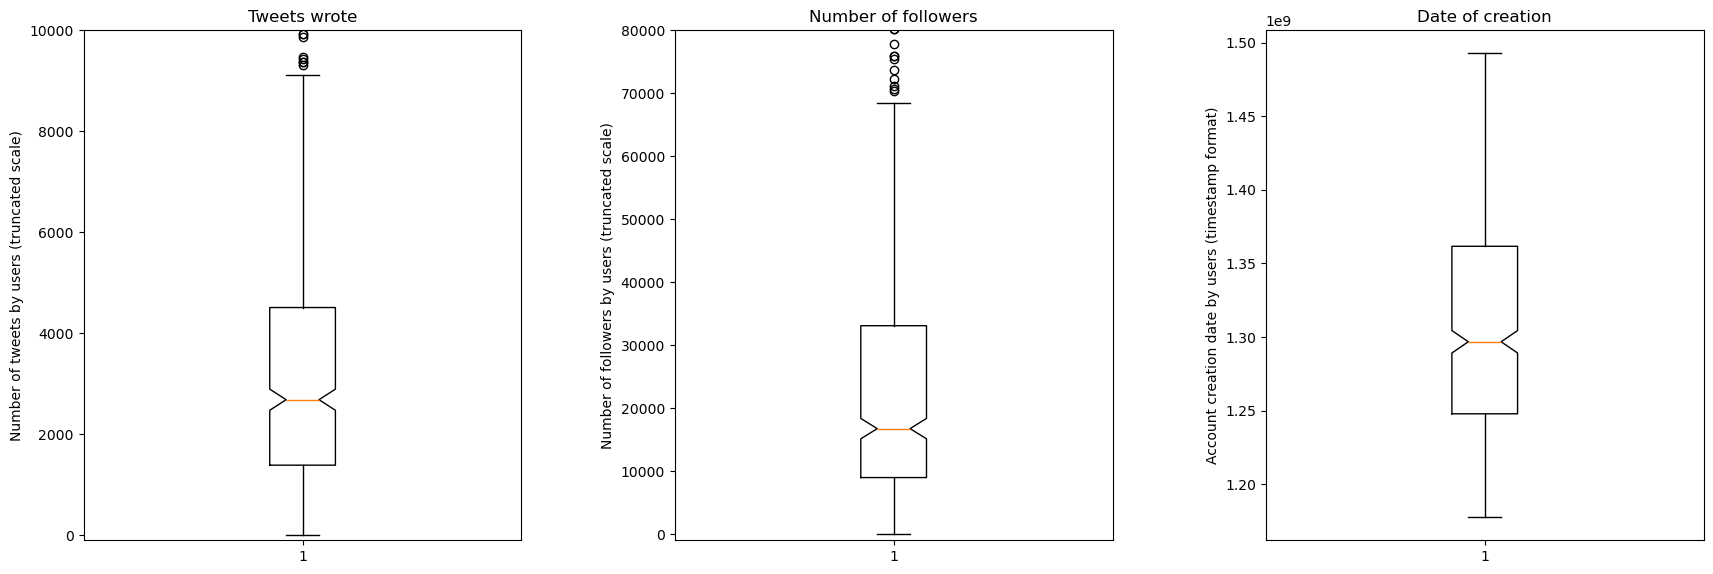

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_figwidth(18)
fig.set_figheight(6)

ax1.boxplot(users_tbl['statuses_count'], notch=True)
ax1.set_ylim(-100, 10000)
ax1.set_title('Tweets wrote')
ax1.set_ylabel('Number of tweets by users (truncated scale)')

ax2.boxplot(users_tbl['followers_count'], notch=True)
ax2.set_ylim(-1e3, 8e4)
ax2.set_title('Number of followers')
ax2.set_ylabel('Number of followers by users (truncated scale)')

ax3.boxplot(pd.to_datetime(users_tbl['created_at']).apply(dt.timestamp), notch=True)
ax3.set_title('Date of creation')
ax3.set_ylabel('Account creation date by users (timestamp format)')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.8, wspace=0.35)

# plt.tight_layout()

plt.show()

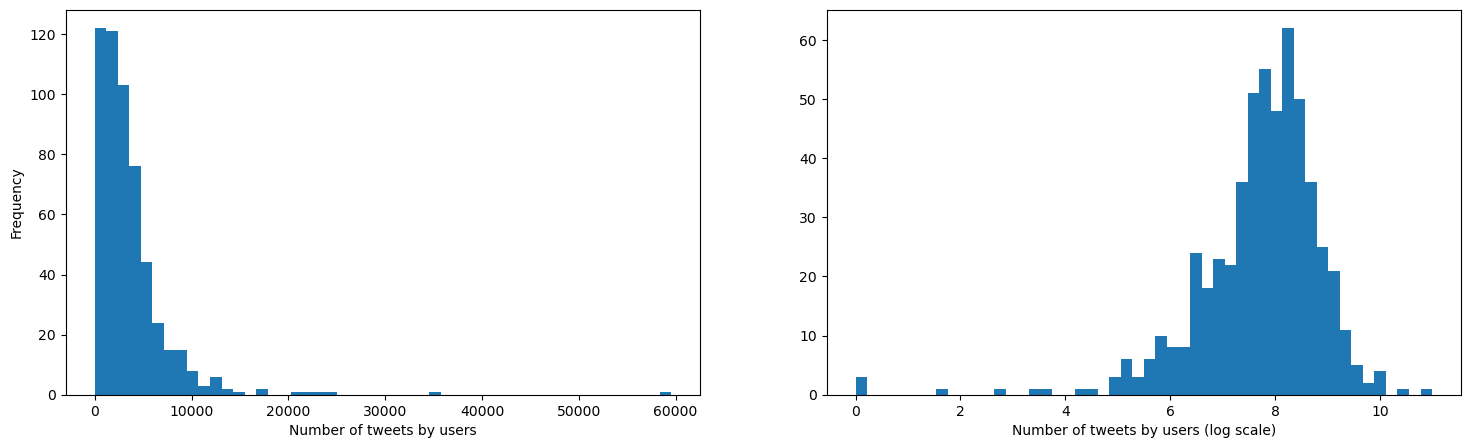

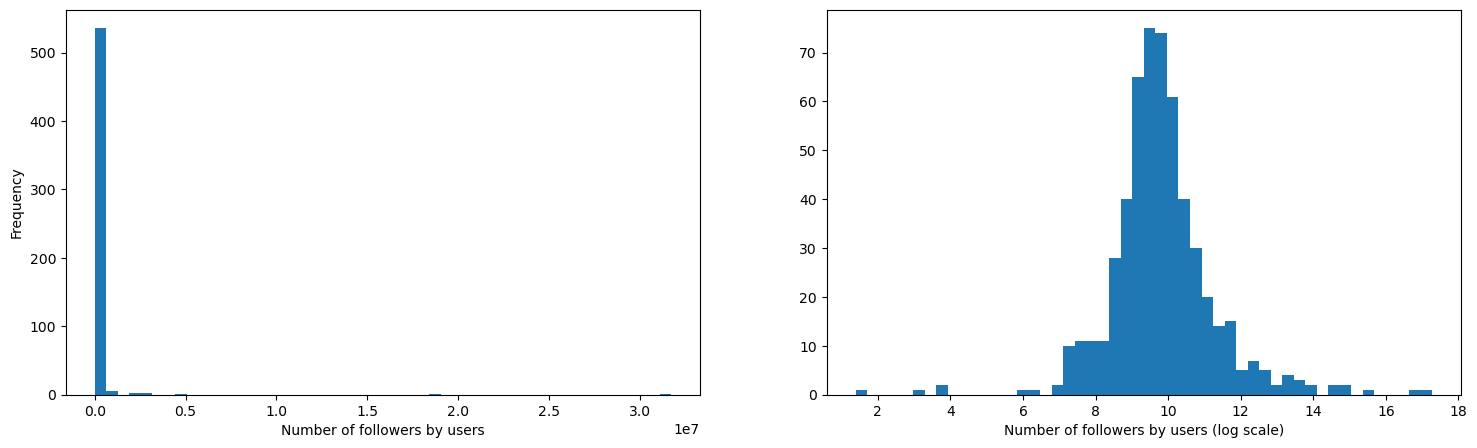

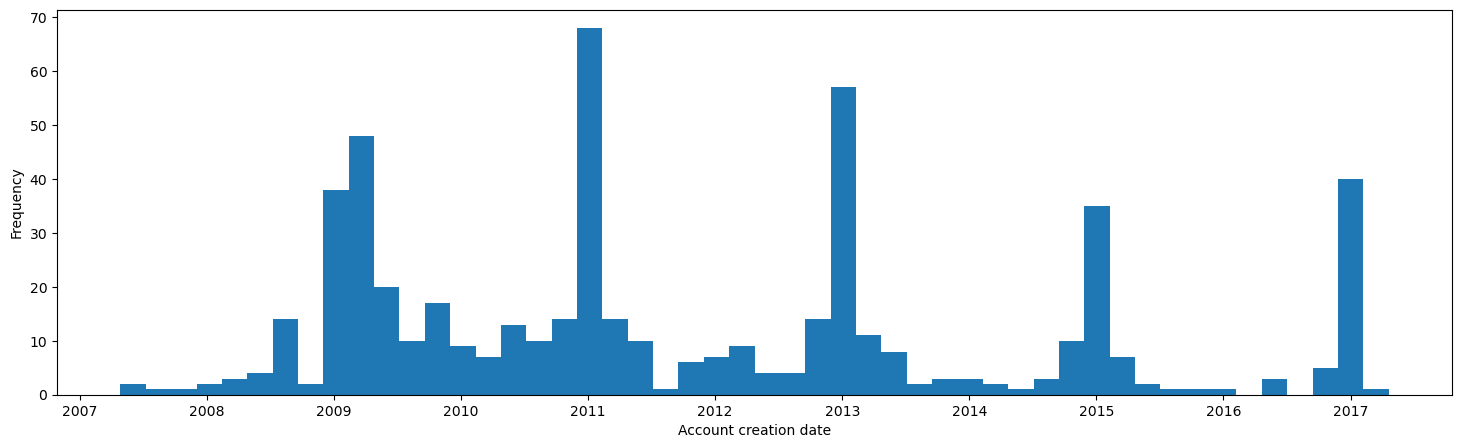

In [21]:
fig1, ax1 = plt.subplots(1,2)
fig2, ax2 = plt.subplots(1,2)
fig3, ax3 = plt.subplots()
fig1.set_size_inches(18,5)
fig2.set_size_inches(18,5)
fig3.set_size_inches(18,5)


ax1[0].hist(users_tbl['statuses_count'], 50)
ax1[0].set_ylabel('Frequency')
ax1[0].set_xlabel('Number of tweets by users')

ax1[1].hist(np.log(users_tbl['statuses_count']+1), 50)
ax1[1].set_xlabel('Number of tweets by users (log scale)')


ax2[0].hist(users_tbl['followers_count'], 50)
ax2[0].set_ylabel('Frequency')
ax2[0].set_xlabel('Number of followers by users')

ax2[1].hist(np.log(users_tbl['followers_count']), 50)
ax2[1].set_xlabel('Number of followers by users (log scale)')

ax3.hist(pd.to_datetime(users_tbl['created_at']), 50)
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Account creation date')

plt.show()

## Top 10 congress members

In [22]:
%%sql 
SELECT
    name            AS 'Twitter name',
    followers_count AS 'followers',
    statuses_count  AS 'tweets',
    created_at      AS 'from'
FROM
    users
GROUP BY
    followers_count
ORDER BY
    followers_count DESC
LIMIT 10

Running query in 'sqlite:///data/CongressTweets.db'

+------------------+-----------+--------+---------------------+
|   Twitter name   | followers | tweets |         from        |
+------------------+-----------+--------+---------------------+
| Donald J. Trump  |  31712585 | 35014  | 2009-03-18 16:46:38 |
| President Trump  |  18545354 |  641   | 2017-01-20 01:54:28 |
|  Bernie Sanders  |  5072538  | 16858  | 2009-04-07 16:02:35 |
|   Cory Booker    |  3094413  | 59535  | 2008-08-11 17:41:16 |
|   Marco Rubio    |  2554822  |  6440  | 2008-08-06 06:07:06 |
| Elizabeth Warren |  2412087  |  2027  | 2012-11-25 18:14:27 |
|   John McCain    |  2274034  | 12886  | 2009-01-23 16:42:31 |
|   Nancy Pelosi   |  1126205  |  5362  | 2008-08-07 18:35:02 |
|   Jerry Brown    |  1119275  |  2116  | 2009-01-24 01:42:45 |
| Senator Ted Cruz |   960413  |  5976  | 2013-01-09 21:11:37 |
+------------------+-----------+--------+---------------------+
Truncated to displaylimit of 10.

In [23]:
timeline = %sql SELECT COUNT(name) AS 'account created', STRFTIME('%Y', created_at) AS date FROM users GROUP BY date ORDER BY date ASC
timeline = timeline.DataFrame()
timeline

Running query in 'sqlite:///data/CongressTweets.db'

account created  date
0                 5  2007
1                34  2008
2               123  2009
3                63  2010
4                92  2011
5                45  2012
6                72  2013
7                30  2014
8                34  2015
9                20  2016
10               30  2017

## Twitter popularity

In [24]:
conn = sqlite3.connect('data/CongressTweets.db')

with conn:
    c = conn.cursor()
    query = ("""SELECT 
                    created_at,
                    followers_count AS followers,
                    name            AS pseudo,
                    screen_name     AS account_name,
                    statuses_count  AS tweets_count,
                    users.state     AS state,
                    population,
                    percentage      AS pop_percent
                FROM
                    users
                LEFT JOIN
                    states
                ON
                    users.state = states.state
                """)
    congress_members = pd.read_sql_query(query,conn)

conn.close()

In [25]:
congress_members.sort_values(by='tweets_count').head(3)

created_at  followers         pseudo  account_name  \
547  2016-10-23 21:23:37         41  Yvette Clarke  YvetteClarke   
372  2010-05-25 19:02:26       2473     Rob Bishop  RepRobBishop   
529  2015-04-07 22:36:11         23    tiberipress   tiberipress   

     tweets_count state  population  pop_percent  
547             0               NaN          NaN  
372             0               NaN          NaN  
529             0               NaN          NaN

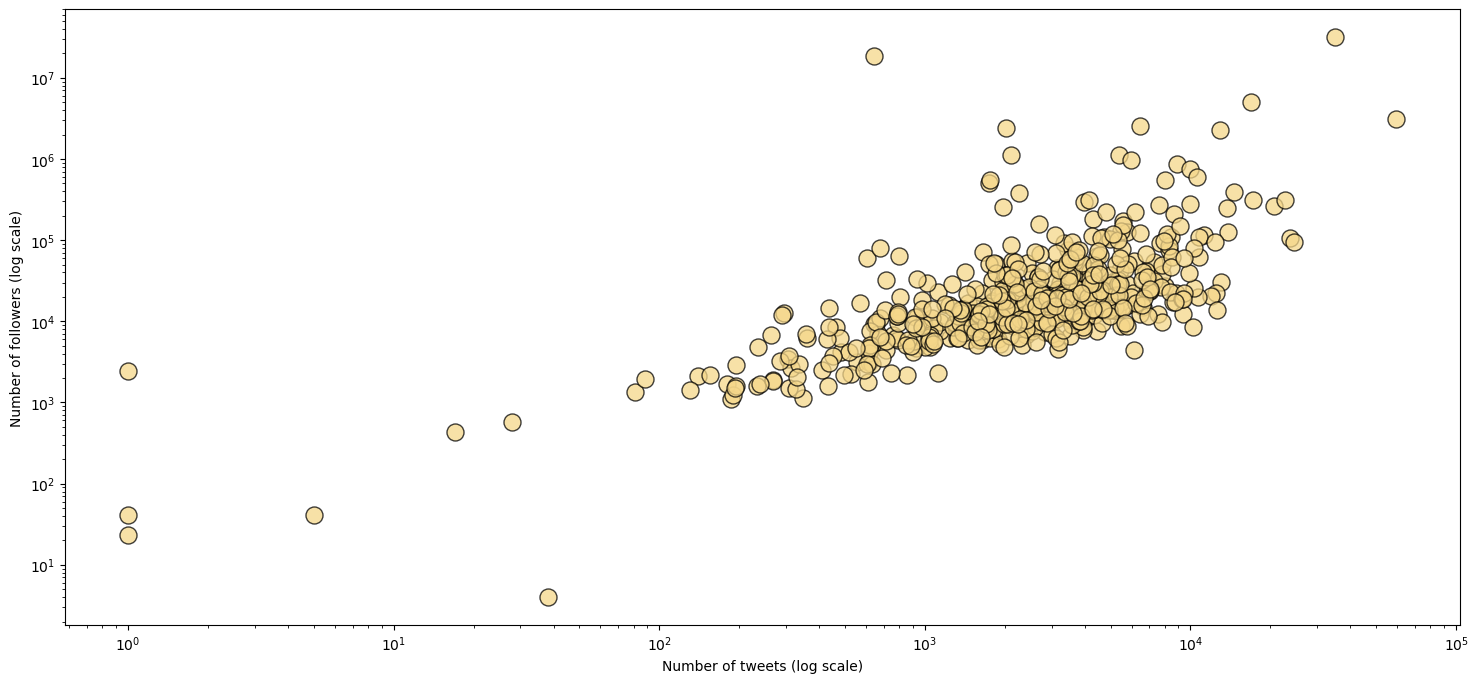

In [26]:
plt.figure(figsize=(18,8))

x = (congress_members['tweets_count']+1)
y = congress_members['followers']

plt.scatter(x, y, 
            s = 150, c='#F5D78A', alpha=0.75,
            edgecolors='black')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Number of tweets (log scale)')
plt.ylabel('Number of followers (log scale)')

plt.show()

In [27]:
congress_members['date_creation'] =  pd.to_datetime(congress_members['created_at']).dt.year

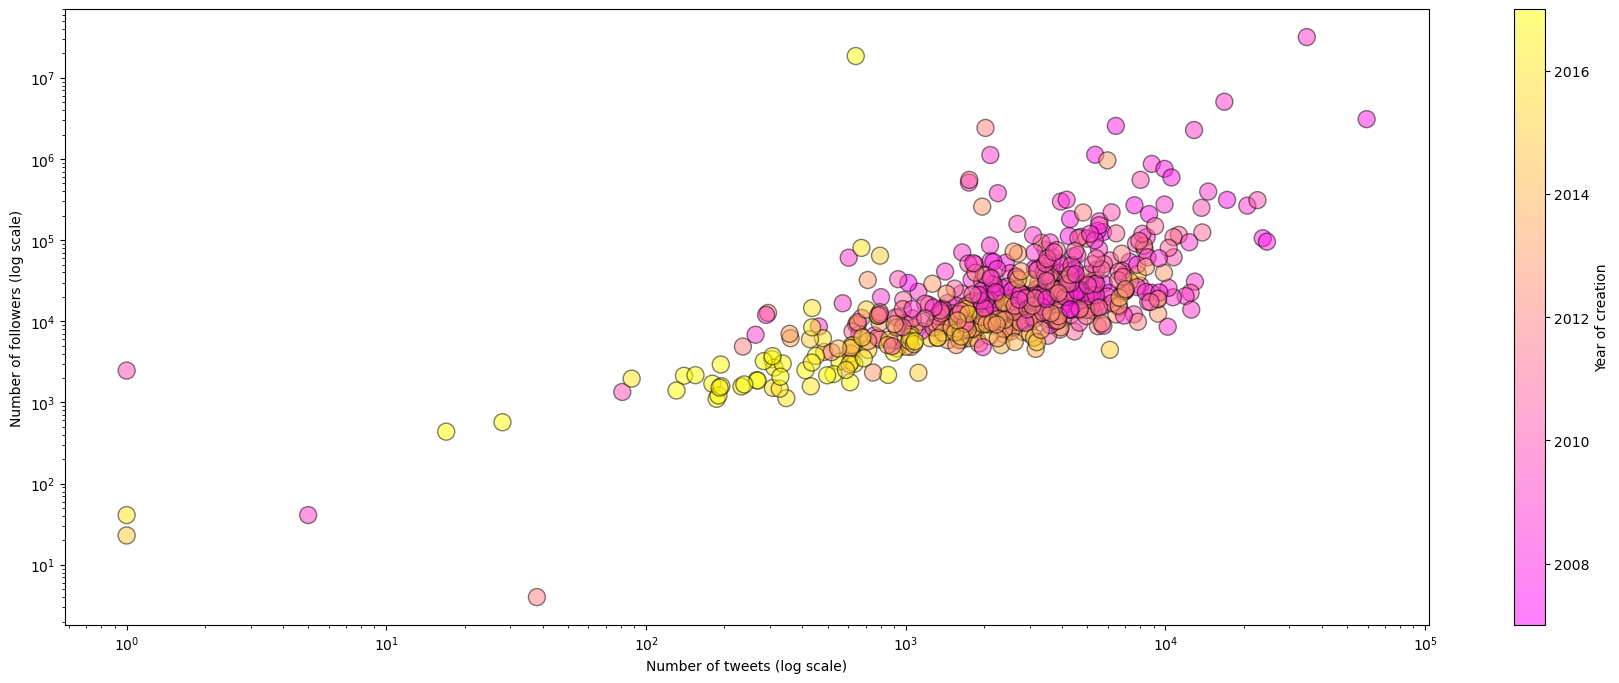

In [28]:
plt.figure(figsize=(22,8))

x = (congress_members['tweets_count']+1)
y = congress_members['followers']
z = congress_members['date_creation']

plt.scatter(x, y, 
            s = 150, c=z, cmap='spring', alpha=0.5,
            edgecolors='black')

# Cmap legend
cbar = plt.colorbar()
cbar.set_label('Year of creation')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Number of tweets (log scale)')
plt.ylabel('Number of followers (log scale)')

plt.show()

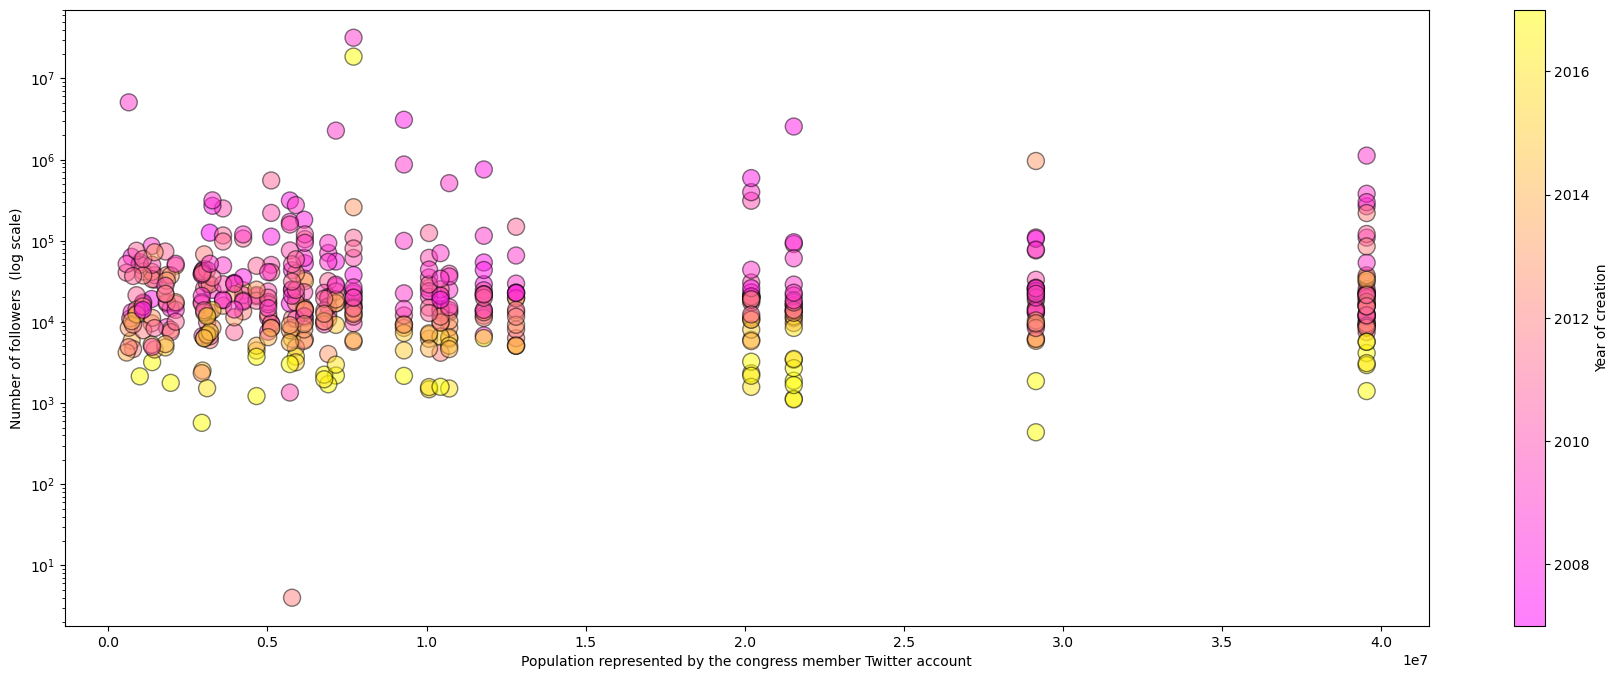

In [29]:
plt.figure(figsize=(22,8))

x = congress_members['population']
y = congress_members['followers']
z = congress_members['date_creation']

plt.scatter(x, y, 
            s = 150, c=z, cmap='spring', alpha=0.5,
            edgecolors='black')

# Cmap legend
cbar = plt.colorbar()
cbar.set_label('Year of creation')

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Population represented by the congress member Twitter account')
plt.ylabel('Number of followers  (log scale)')

plt.show()

In [30]:
congress_members['date_creation'] = pd.to_datetime(congress_members['created_at']).apply(lambda x: x.timestamp())
# congress_members['date_creation'] = congress_members['date_creation'] - congress_members['date_creation'].min() / (congress_members['date_creation'].max() - congress_members['date_creation'].min())

transdf_congress = pd.DataFrame.join(np.log(congress_members[['followers']]),
                                     np.log(congress_members[['tweets_count']]+1))
transdf_congress = pd.DataFrame.join(transdf_congress, congress_members[['date_creation', 'pop_percent']])

In [31]:
transdf_congress.corr()

followers  tweets_count  date_creation  pop_percent
followers       1.000000      0.693832      -0.522994    -0.001141
tweets_count    0.693832      1.000000      -0.513589    -0.037781
date_creation  -0.522994     -0.513589       1.000000     0.031143
pop_percent    -0.001141     -0.037781       0.031143     1.000000

In [32]:
transdf_congress.corr()**2

followers  tweets_count  date_creation  pop_percent
followers       1.000000      0.481403       0.273523     0.000001
tweets_count    0.481403      1.000000       0.263774     0.001427
date_creation   0.273523      0.263774       1.000000     0.000970
pop_percent     0.000001      0.001427       0.000970     1.000000

In [33]:
F, p_value = stats.f_oneway(transdf_congress['followers'],
                            transdf_congress['tweets_count'],
                            transdf_congress['date_creation'])

print(f"ANOVA p-value: {p_value}")

print('--------------------------------------------------------------')

r1, p1 = stats.pearsonr(transdf_congress['followers'], transdf_congress['tweets_count'])
r2, p2 = stats.pearsonr(transdf_congress['followers'], transdf_congress['date_creation'])

filt = transdf_congress['pop_percent'].isna()
r3, p3 = stats.pearsonr(transdf_congress.loc[~filt, 'followers'], transdf_congress.loc[~filt,'pop_percent'])

print(f"""Normal law p-value followers/tweet_count: {p1}
Normal law p-value followers/date_creation: {p2}
Normal law p-value followers/pop_percent: {p3}""")

ANOVA p-value: 0.0
--------------------------------------------------------------
Normal law p-value followers/tweet_count: 6.911124553209872e-80
Normal law p-value followers/date_creation: 8.435863996934327e-40
Normal law p-value followers/pop_percent: 0.9800010002670188


## Regression

In [34]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

Y = transdf_congress['followers']
Z = transdf_congress[['tweets_count', 'date_creation']]
lm.fit(Z, Y)

print(f"""Coefficient of determination: {lm.score(Z,Y)}

-------------------------------------------------------

Tweet counts beta coefficient value: {lm.coef_[0]}
Date of creation (timestamp format) beta coefficient value: {lm.coef_[1]}
Intercept value: {lm.intercept_}""")

Coefficient of determination: 0.5191256036634659

-------------------------------------------------------

Tweet counts beta coefficient value: 0.7016007548924776
Date of creation (timestamp format) beta coefficient value: -4.205667741675959e-09
Intercept value: 9.95642969793451


- 0.52 value for coefficient of determination shows that there isn't strong linear relation but enough to analyze


In [35]:
print(f"""Tweets count coefficient:
    Predictor factor: {np.exp(1)} and response factor: {np.exp(7.01599956e-01)}
    Predictor lower factor: {np.exp(1)/2} and response lower factor: {np.exp(7.01599956e-01 * np.log(np.exp(1)/2))}

------------------

Creation date coefficient:
    Response factor: {np.exp(4.20569491e-09)}
    Response greater factor {np.exp(4.20569491e-09*3600*24*7*52.17857)}""")

Tweets count coefficient:
    Predictor factor: 2.718281828459045 and response factor: 2.016977202034168
    Predictor lower factor: 1.3591409142295225 and response lower factor: 1.2402189351262167

------------------

Creation date coefficient:
    Response factor: 1.000000004205695
    Response greater factor 1.1419320790852165


- There is a %35 increase in tweets and a %24 increase in followers
- There is a %14 increase in followers each year.

### Conclussion

- A correlation between # of followers and # of tweets is observed.
- The population of state don't have a clear effect on # of followers of congress member
- Older counts have more tweets (dah!)


## Congress members tweets

In [36]:
tweets = %sql SELECT created_at, screen_name, text FROM tweets
tweets = tweets.DataFrame()

Running query in 'sqlite:///data/CongressTweets.db'

In [37]:
# Tokenize to gets the number of words
tweets['words_count'] = tweets['text'].apply(lambda x: len(word_tokenize(x)))

# Get the total length by characters of the text
tweets['characters_length'] = tweets['text'].apply(len)

In [38]:
tweets.head()

created_at  screen_name  \
0  2008-08-04 17:28:51  JohnBoozman   
1  2008-08-06 19:04:45  JohnBoozman   
2  2008-08-06 20:35:36  JohnBoozman   
3  2008-08-07 13:52:52  JohnBoozman   
4  2008-08-07 15:12:05  JohnBoozman   

                                                                                         text  \
0                  On a conference call about a weekend trip to Iraq to visit Arkansas troops   
1                                                                   Being interviewed by KTHV   
2                           Being interviewed by KARN on his Arkansas World Trade Center trip   
3                                                       On KWHN in Fort Smith, that's 1320 AM   
4  Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville   

   words_count  characters_length  
0           14                 74  
1            4                 25  
2           11                 65  
3           10                 37  
4           15                 90

In [39]:
%sql SELECT COUNT(id) AS 'Tweets count' FROM tweets

Running query in 'sqlite:///data/CongressTweets.db'

+--------------+
| Tweets count |
+--------------+
|   1243370    |
+--------------+

In [40]:
print("""/!\ Rows are not bounded by features in the table below.
    For ex: MAX row doesn't display the same data point.""")

fivenum('tweets', 'words_count').merge(
        fivenum('tweets', 'characters_length')).merge(
            fivenum('tweets', 'created_at')).set_index("Stat")

/!\ Rows are not bounded by features in the table below.
    For ex: MAX row doesn't display the same data point.


words_count  characters_length           created_at
Stat                                                       
MIN               1                  1  2008-08-04 17:28:51
Q1               20                113  2014-06-11 18:36:43
MEDIAN           24                134  2015-11-05 21:31:43
MEAN             23                123                 2014
Q3               27                140  2016-09-28 21:18:01
MAX             107                415  2017-06-06 17:16:00

In [41]:
# Tweets with above characters limit
filt = tweets['characters_length'] > 140

limit = tweets[filt].shape[0]
total = tweets.shape[0]

print(f"Number of tweets above the characters limit {limit} ({round(limit*100/total,1)}%)")
tweets.loc[filt, ['text', 'characters_length']].head(3)

Number of tweets above the characters limit 185971 (15.0%)


text  \
4935   3Keys To Health Care Reform:Tort Reform,AHPS& Competition Across State Lines.VideoLink: http://bit.ly/3tBWT5 --(PlzRT&gt; http://bit.ly/wLFIi )   
17068    RT @ChipBoyd: Door knocking for @BillHaslam! Hit &gt;250 doors b4 we got rained out! Phone calls next! Visit us in JC next to Vitamin Shoppe!   
21264    The letter I sent to AG Eric Holder asking the Justice Dept to prosecute those responsible for the Wikileaks fiasco--&gt; http://goo.gl/E5JMo   

       characters_length  
4935                 143  
17068                141  
21264                141

### Discussion

- words_count seems to follow a roughly normal curve with some outliers. Since the median and mean values are similar, there isn't any evidence of skewness. This is expected as Twitter limit the number of characters by tweet to a low amount, 140 in total. This necessarily implies having a limited number of words but leaves a little flexibility in the way of constructing a concise message.

- characters_length should be similar to words_count pattern, but seems to have a distinct difference. Indeed, the median is greater than the mean, which is a marker left skewness. Also, the hard limit of 140 characters is crossed, which should be impossible. One reason of that situation it's the way of how Twitter process URL. Indeed, URL links are shorten when tweets are written. It is confirmed by the second dataframe above, which show some of the tweets above the character limit and actually embedding some URL at the tweet end.

- created_at is probably not under the normal assumption, since as the time passed the more Congress members get on Twitter, even if a lot of them subscribe since the beginning, as seen previously. However, they are more incline to tweet. Indeed, Trump-time showed how much social media and its favorite one, Twitter, were political battlegrounds and tools to work with.

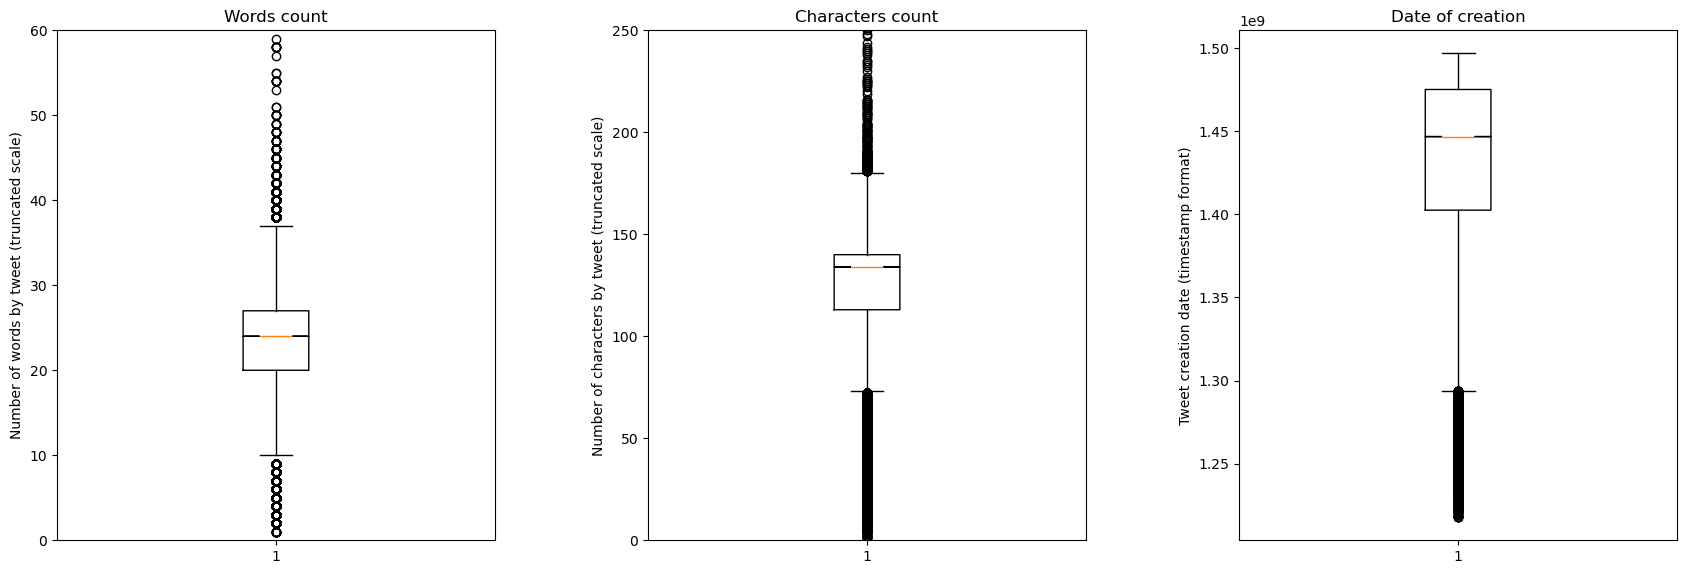

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_figwidth(18)
fig.set_figheight(6)

ax1.boxplot(tweets['words_count'], notch=True)
ax1.set_ylim(0, 60)
ax1.set_title('Words count')
ax1.set_ylabel('Number of words by tweet (truncated scale)')

ax2.boxplot(tweets['characters_length'], notch=True)
ax2.set_ylim(0, 250)
ax2.set_title('Characters count')
ax2.set_ylabel('Number of characters by tweet (truncated scale)')

ax3.boxplot(pd.to_datetime(tweets['created_at']).apply(dt.timestamp), notch=True)
ax3.set_title('Date of creation')
ax3.set_ylabel('Tweet creation date (timestamp format)')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.8, wspace=0.35)

# plt.tight_layout()

plt.show()

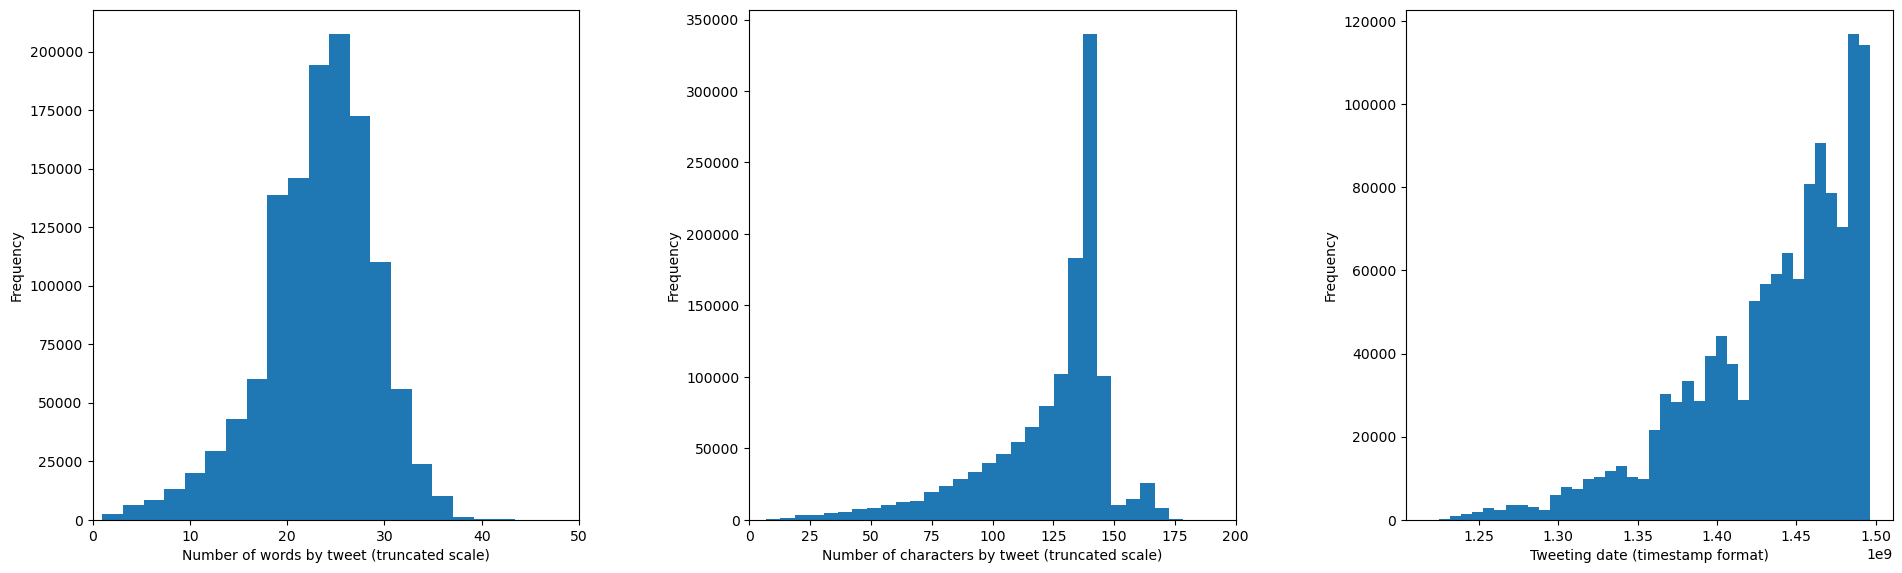

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

fig.set_figwidth(20)
fig.set_figheight(6)


ax1.hist(tweets['words_count'], 50)
ax1.set_xlim(0,50)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Number of words by tweet (truncated scale)')

ax2.hist(tweets['characters_length'],70)
ax2.set_xlim(0,200)
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Number of characters by tweet (truncated scale)')

ax3.hist(pd.to_datetime(tweets['created_at']).apply(dt.timestamp),40)
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Tweeting date (timestamp format)')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.8, wspace=0.35)


plt.show()

## Most used words

In [78]:
from nltk.corpus import stopwords
import string

stopwrds_lst = list(stopwords.words('english'))
stopwrds_lst.extend(('w', "'", 'th', "'s", "'t", "n't", "http", "https", "'m"))
stopwrds_lst = set(stopwrds_lst)

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

tweets['clean_text'] = tweets['text'].str.lower()
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: remove_punct(x))
tweets['clean_text'] = tweets['clean_text'].str.replace("’", "")
tweets['clean_text'] = tweets['clean_text'].str.replace('thanks', "thank")
tweets['clean_text'] = tweets['clean_text'].str.replace('americans', "american")
tweets['clean_text'] = tweets['clean_text'].str.replace('amp', "")
tweets['clean_text'] = tweets['clean_text'].transform(word_tokenize)
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: [words for words in x if words not in stopwrds_lst])

In [76]:
tweets[['text', 'clean_text']].head()

text  \
0                  On a conference call about a weekend trip to Iraq to visit Arkansas troops   
1                                                                   Being interviewed by KTHV   
2                           Being interviewed by KARN on his Arkansas World Trade Center trip   
3                                                       On KWHN in Fort Smith, that's 1320 AM   
4  Attending a Military of the Purple Heart Ceremony at the VA Medical Center in Fayetteville   

                                                                          clean_text  
0                   [conference, call, weekend, trip, iraq, visit, arkansas, troops]  
1                                                                [interviewed, kthv]  
2                          [interviewed, karn, arkansas, world, trade, center, trip]  
3                                                         [kwhn, fort, smith, thats]  
4  [attending, military, purple, heart, ceremony, va, medical, center, fayetteville]

In [79]:
from nltk.probability import FreqDist

agg_corpus = ' '.join(tweets['clean_text'].str.join(' ')).split(' ') #must be tokens single list
fdist = FreqDist(agg_corpus)

top10_words = fdist.most_common(10)

top10_words

[('rt', 267404),
 ('today', 103709),
 ('thank', 86161),
 ('great', 71605),
 ('us', 60507),
 ('american', 49957),
 ('bill', 47619),
 ('house', 47329),
 ('new', 45566),
 ('day', 39128)]

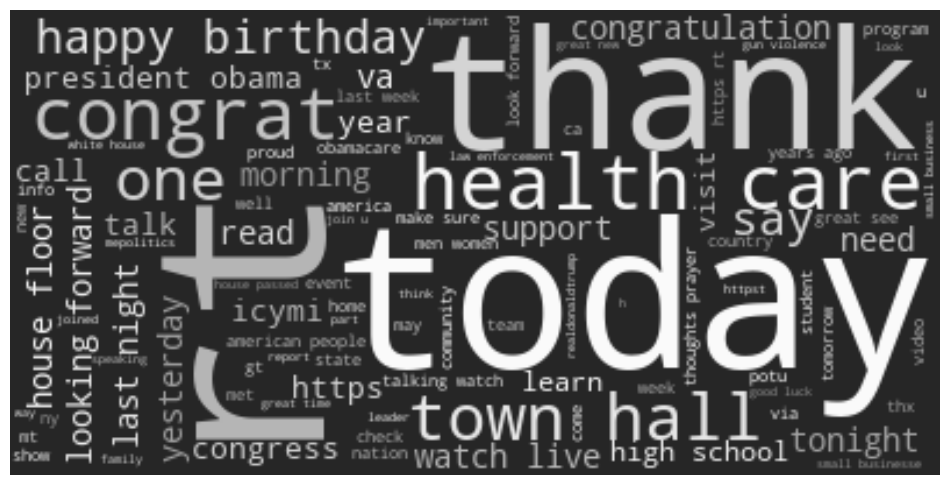

In [81]:
from wordcloud import WordCloud
from PIL import Image
import random


def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


#congress_color = np.array(Image.open('./figures/congress.png'))

# instantiate a word cloud object
tweets_wc = WordCloud(
    background_color='#262626',
    max_words=100)
#,
#    mask=congress_color)

# generate the word cloud
tweets_wc.generate(' '.join(tweets['clean_text'].str.join(' ')))

# display the word cloud
plt.figure(figsize=(12,9))
plt.imshow(tweets_wc.recolor(color_func=grey_color_func), interpolation='bilinear')
plt.axis('off')
plt.show()

In [82]:
topwords_year = tweets.copy()
topwords_year['created_at'] = topwords_year['created_at'].apply(lambda x: x[0:4])

summary_df = pd.DataFrame()

for year in topwords_year['created_at'].unique():
    
    filt = topwords_year['created_at'] == year
    agg_corpus = ' '.join(tweets.loc[filt, 'clean_text'].str.join(' ')).split(' ') #must be tokens single list
    
    fdist = FreqDist(agg_corpus)
    top10_words = fdist.most_common(10)

    summary_df[year] = top10_words
    
summary_df

2008           2009           2010           2011  \
0  (attending, 15)    (tcot, 761)     (rt, 1548)     (rt, 5430)   
1    (bailout, 11)  (health, 669)   (tcot, 1182)   (jobs, 3977)   
2       (thank, 9)   (today, 618)  (today, 1147)  (today, 2984)   
3    (arkansas, 7)      (rt, 580)     (gop, 929)  (house, 2286)   
4     (meeting, 7)    (bill, 577)     (new, 814)  (thank, 1934)   
5    (earmarks, 7)    (care, 523)   (great, 787)  (great, 1740)   
6        (pork, 7)   (great, 503)   (house, 753)    (gop, 1690)   
7          (im, 7)   (house, 444)    (bill, 749)   (bill, 1606)   
8       (floor, 7)     (new, 395)   (thank, 658)     (us, 1592)   
9     (hearing, 6)   (masen, 374)  (health, 644)    (new, 1554)   

            2012               2013              2014               2015  \
0     (rt, 9813)        (rt, 23452)       (rt, 37514)        (rt, 58387)   
1  (today, 4673)     (today, 11633)    (today, 15666)     (today, 22807)   
2   (jobs, 3550)      (thank, 8026)    (thank, 11503)     (thank, 17913)   
3  (thank, 3106)  (obamacare, 7355)    (great, 10467)     (great, 15822)   
4  (great, 2686)      (great, 7189)        (us, 7584)        (us, 13216)   
5    (new, 2454)      (house, 7063)     (house, 7218)      (bill, 11377)   
6     (us, 2311)         (us, 5456)       (new, 6442)  (american, 10204)   
7  (house, 2260)       (bill, 5438)  (american, 6300)      (house, 9683)   
8    (day, 1880)        (new, 4666)      (bill, 6140)        (new, 8587)   
9   (bill, 1781)   (american, 4305)       (day, 6004)        (act, 8387)   

                2016               2017  
0        (rt, 80251)        (rt, 50429)  
1     (today, 27998)     (thank, 16313)  
2     (thank, 26351)     (today, 16182)  
3     (great, 20404)  (american, 12773)  
4        (us, 17929)     (great, 12003)  
5  (american, 13005)        (us, 11626)  
6       (new, 12790)    (health, 10205)  
7      (bill, 11137)      (trump, 9521)  
8      (help, 11089)       (care, 8968)  
9       (day, 11055)       (bill, 8810)

In [86]:
def tidypy(df):
    tidy_df = pd.DataFrame()
    slice_df = pd.DataFrame()
    
    for col in df.columns:
        slice_df['word'] = df[col].apply(lambda x: x[0])
        slice_df['frequency'] = df[col].apply(lambda x: x[1])
        slice_df['year'] = col
        slice_df['color'] = list(map(lambda col: matplotlib.colors.to_hex(col),
                                  cm.YlOrRd(range(0,10))))
        tidy_df = pd.concat([tidy_df, slice_df])
        
    return tidy_df
    
motion_chart = tidypy(summary_df)

px.bar(motion_chart,
       x="frequency", y="word", animation_frame="year",
       range_x=[1,10e4], log_x=True,
       color="frequency", color_continuous_scale=px.colors.sequential.Blugrn)

## Conclussion

 - "american", "US", "bill", "care", "health", "house", "congress" are all words that are connected with politics and law and they are expected.

- The contextual words specific to writing a tweet, such as "today", "yesterday", "thank", "great" is not supreising but What is just surprising is to see how they are consistently at the top of the ranking of the most used words per year.

- The most used words on Twitter would be "rt", it is not important but I kept for possible usage for further analysis about retweet connection.


## Congress members Twitter color profile

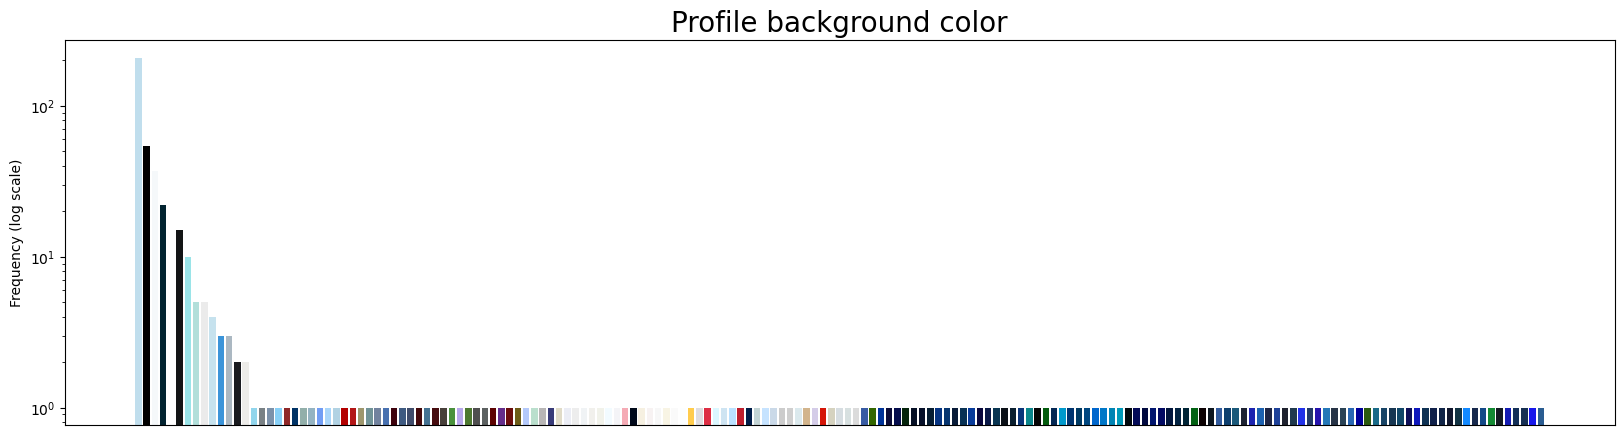

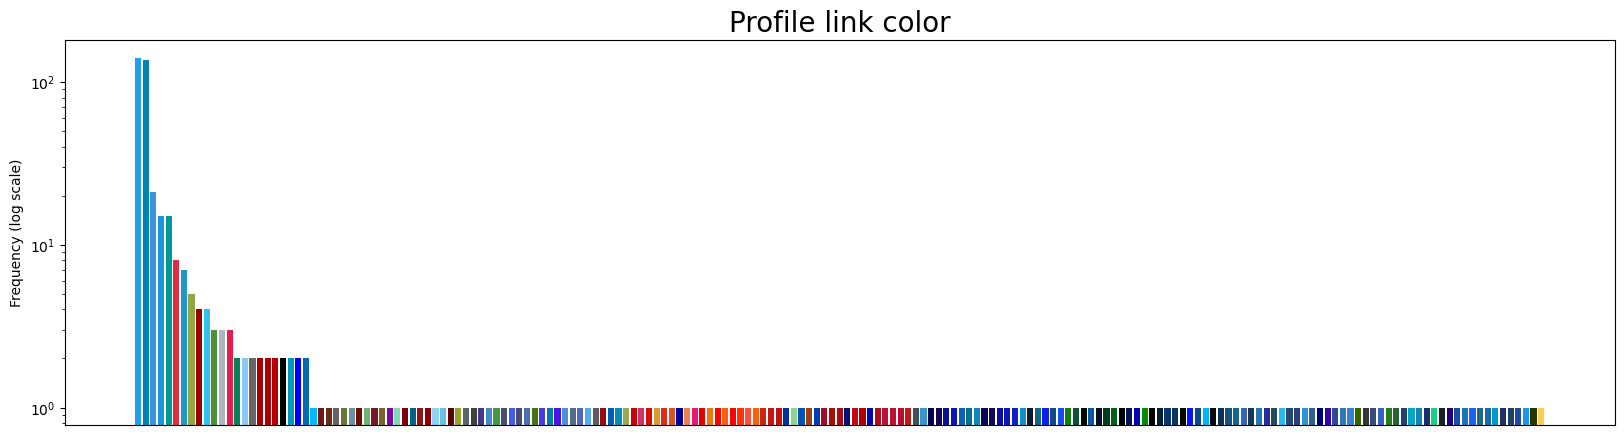

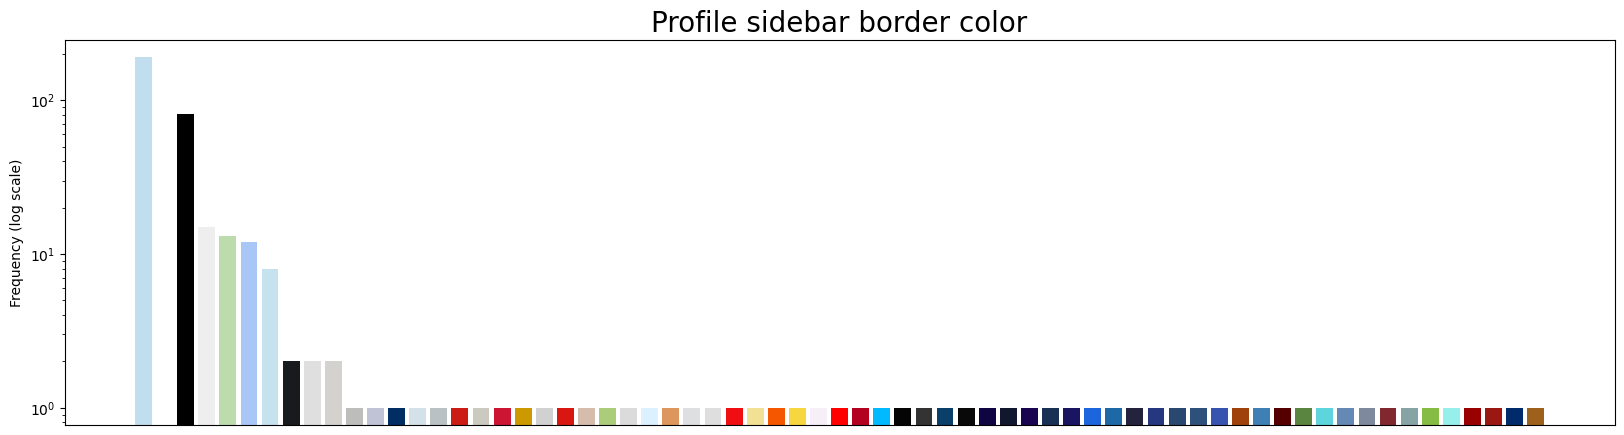

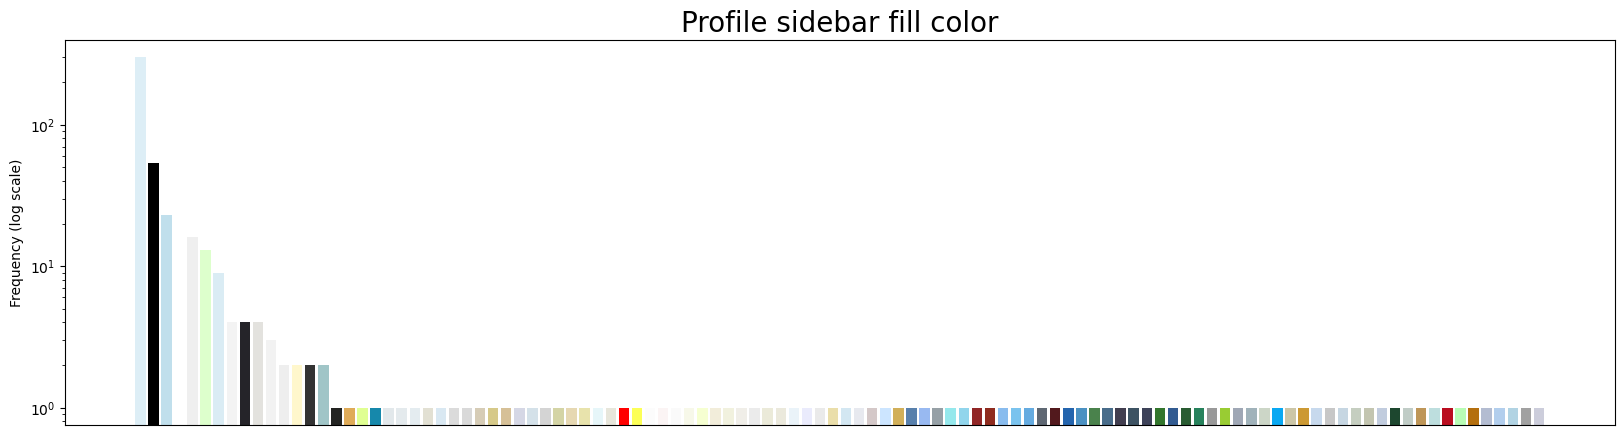

In [87]:
def color_barplot(df, col_name):
    color_count_df = df[[col_name]].value_counts().to_frame()
    color_count_df.reset_index(inplace=True)

    plt.figure(figsize=(20,5))
    plt.bar(color_count_df.iloc[:,0],
            color_count_df.iloc[:,1],
            color=color_count_df.iloc[:,0].apply(lambda x: '#'+x) )

    plt.yscale('log')
    plt.title(col_name[0].upper()+col_name[1:len(col_name)].replace("_", " "),
             fontsize='20')
    plt.tick_params(axis='x',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False)
    plt.ylabel('Frequency (log scale)')
    plt.show()
    
color_barplot(users_tbl, 'profile_background_color')
color_barplot(users_tbl, 'profile_link_color')
color_barplot(users_tbl, 'profile_sidebar_border_color')
color_barplot(users_tbl, 'profile_sidebar_fill_color')

## Conclusion

Unsurprisingly, it is difficult to see a true distinction between the colors used due to several reasons:

- there are several shades for the same color (or range), which dissociates the data instead of grouping them and consequently makes the analysis much more difficult. To avoid this situation would be to group the hexadecimal RGB(A) values, which is a complex task.
- blue and white are widely used on all types of media and functions. Especially since they are strongly present in many photos of landscapes or people. There is therefore a strong dominance of these colors as it can be seen in the graphs above.
- there is no additional information include in the dataset to define the difference between variables. Thanks to the explicit names, it is easy to assume the role of some of these variables, like "profile background color", but much less for others, like "profile link color". This information could be useful to obtain a better analysis.

From the observation of the distributions of the different variables linked to the colors, it is difficult to obtain convincing results. However, "profile link color" seems to contain mostly only shades of red and blue. There is therefore at least one of the variables which verifies our initial hypothesis.